In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

ModuleNotFoundError: No module named 'statsmodels'

In [2]:
data = pd.read_csv('baba_long_data.csv')

In [3]:
data

,Date,Close,High,Low,Open,Volume
0,2014-09-19,90.673950,96.284936,86.868906,89.524709,271879400
1,2014-09-22,86.810966,89.766149,86.434326,89.524712,66657800
2,2014-09-23,84.184128,87.380754,83.652972,85.893503,39009800
3,2014-09-24,87.467667,87.467667,84.232417,85.439600,32088000
4,2014-09-25,85.874191,88.365819,85.468579,87.969860,28598000
...,...,...,...,...,...,...
2601,2025-01-23,86.099998,86.199997,84.959999,85.800003,9225600
2602,2025-01-24,89.139999,89.190002,86.480003,86.709999,18791000
2603,2025-01-27,89.989998,91.430000,89.220001,90.589996,25999800
2604,2025-01-28,96.029999,96.430000,89.900002,90.940002,31296300


In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [5]:
data

,Close,High,Low,Open,Volume
Date,,,,,
2014-09-19,90.673950,96.284936,86.868906,89.524709,271879400
2014-09-22,86.810966,89.766149,86.434326,89.524712,66657800
2014-09-23,84.184128,87.380754,83.652972,85.893503,39009800
2014-09-24,87.467667,87.467667,84.232417,85.439600,32088000
2014-09-25,85.874191,88.365819,85.468579,87.969860,28598000
...,...,...,...,...,...
2025-01-23,86.099998,86.199997,84.959999,85.800003,9225600
2025-01-24,89.139999,89.190002,86.480003,86.709999,18791000
2025-01-27,89.989998,91.430000,89.220001,90.589996,25999800


In [6]:
# check the frequency
print(data.index.freq)

None


In [7]:
# Set the frequency to daily
data = data.resample('D').ffill()

In [8]:
print(data.index.freq)

<Day>


In [9]:
# check for missing
data.isnull().sum()

,0
Close,0
High,0
Low,0
Open,0
Volume,0


## Stationarity Check

In [10]:
# Perform ADF test
result = adfuller(data['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Interpret the result
if result[1] <= 0.05:
    print("The data is stationary (reject the null hypothesis).")
else:
    print("The data is non-stationary (fail to reject the null hypothesis).")

ADF Statistic: -1.4253815469523163
p-value: 0.5700492279846185
Critical Values:
   1%: -3.4320926833394925
   5%: -2.86231002141224
   10%: -2.5671798929611827
The data is non-stationary (fail to reject the null hypothesis).


In [11]:
# Apply differencing
data['Close_diff'] = data['Close'].diff().dropna()

In [12]:
data

,Close,High,Low,Open,Volume,Close_diff
Date,,,,,,
2014-09-19,90.673950,96.284936,86.868906,89.524709,271879400,NaN
2014-09-20,90.673950,96.284936,86.868906,89.524709,271879400,0.000000
2014-09-21,90.673950,96.284936,86.868906,89.524709,271879400,0.000000
2014-09-22,86.810966,89.766149,86.434326,89.524712,66657800,-3.862984
2014-09-23,84.184128,87.380754,83.652972,85.893503,39009800,-2.626839
...,...,...,...,...,...,...
2025-01-25,89.139999,89.190002,86.480003,86.709999,18791000,0.000000
2025-01-26,89.139999,89.190002,86.480003,86.709999,18791000,0.000000
2025-01-27,89.989998,91.430000,89.220001,90.589996,25999800,0.849998


In [13]:
# drop Na from close_diff
data.dropna(inplace=True)

In [14]:
# Use only the 'Close_diff' column
data = data[['Close_diff']]

In [15]:
data

,Close_diff
Date,
2014-09-20,0.000000
2014-09-21,0.000000
2014-09-22,-3.862984
2014-09-23,-2.626839
2014-09-24,3.283539
...,...
2025-01-25,0.000000
2025-01-26,0.000000
2025-01-27,0.849998


## Train-Test split

In [18]:
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Models

## ARIMA

### Determine ARIMA Parameters:

In [16]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.5 MB/s eta 0:00:00


In [19]:
from pmdarima import auto_arima

model_arima = auto_arima(train['Close_diff'], seasonal=False, trace=True)
print(model_arima.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=15426.320, Time=2.84 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=15431.189, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=15427.740, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=15427.845, Time=0.16 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=15431.519, Time=0.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=15426.331, Time=0.65 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0]             : AIC=15428.288, Time=2.16 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0]             : AIC=15411.469, Time=5.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0]             : AIC=15426.329, Time=0.91 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[0]             : AIC=15413.388, Time=2.56 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,4)(0,0,0)[0]             : AIC=15413.233, Time=2.63 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,4)(0,0,0)[0]             : AIC=15421.968, Time=1.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,4)(0,0,0)[0]             : AIC=15414.308, Time=5.64 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=15413.468, Time=5.02 sec

Best model:  ARIMA(2,0,3)(0,0,0)[0]          
Total fit time: 29.392 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3028
Model:               SARIMAX(2, 0, 3)   Log Likelihood               -7699.734
Date:                Wed, 05 Feb 2025   AIC                          15411.469
Time:                        07:24:47   BIC                          15447.563
Sample:                    09-20-2014   HQIC                         15424.445
                         - 01-03-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6087      0.060    -26.771      0.000      -1.72

# Fit ARIMA Model:

In [22]:
model = ARIMA(train['Close_diff'], order=(2, 1, 0))
fitted_model = model.fit()

# Forecaast and Evaluate

In [24]:
# Generate forecasts using the fitted ARIMA model
arima_forecast = fitted_model.predict(start=test.index[0], end=test.index[-1])

mae_arima = mean_absolute_error(test['Close_diff'], arima_forecast)
# Calculate MSE first, then take the square root for RMSE
mse_arima = mean_squared_error(test['Close_diff'], arima_forecast)
rmse_arima = np.sqrt(mse_arima)  # Calculate RMSE using NumPy
print(f'ARIMA MAE: {mae_arima}, RMSE: {rmse_arima}')

ARIMA MAE: 2.165185411330491, RMSE: 2.5632588196651307


# LSTM Model

## Preprocess Data for LSTM

In [28]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train[['Close_diff']])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(scaled_train, seq_length)

## Build LSTM Model:

In [29]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Train LSTM Model

In [30]:
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - loss: 0.0578
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.0027
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0026
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 0.0030
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.0026
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.0027
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 0.0026
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.0030
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0026
Epoch 10/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0025


## Forecast and Evaluate

In [33]:
scaled_test = scaler.transform(test[['Close_diff']])
X_test, y_test = create_sequences(scaled_test, seq_length)
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(predictions)

mae = mean_absolute_error(test['Close_diff'].iloc[seq_length:], predictions)
print('LSTM MAE:', mae)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
LSTM MAE: 1.0641844724757608


# Prophet Model

## Prepare Data for Prophet

In [38]:
train_prophet = train.reset_index()[['Date', 'Close_diff']].rename(columns={'Date': 'ds', 'Close': 'y'})

## Fit Prophet Model

In [39]:
from prophet import Prophet

train_prophet = train.reset_index()[['Date', 'Close_diff']].rename(columns={'Date': 'ds', 'Close_diff': 'y'})

# Remove timezone information from the 'ds' column
train_prophet['ds'] = train_prophet['ds'].dt.tz_localize(None)

model_prophet = Prophet()
model_prophet.fit(train_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp45tgog_/rfrs9hs3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp45tgog_/c1_bm0vz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54029', 'data', 'file=/tmp/tmpp45tgog_/rfrs9hs3.json', 'init=/tmp/tmpp45tgog_/c1_bm0vz.json', 'output', 'file=/tmp/tmpp45tgog_/prophet_modelfhqxdzik/prophet_model-20250205073532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:35:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:35:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Forecast and Evaluate:

In [41]:
future = model_prophet.make_future_dataframe(periods=len(test), freq='H')
forecast = model_prophet.predict(future)
forecast = forecast.iloc[-len(test):]

mae = mean_absolute_error(test['Close_diff'], forecast['yhat'])
print('Prophet MAE:', mae)

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


Prophet MAE: 1.1530531706395644


# Compare Models

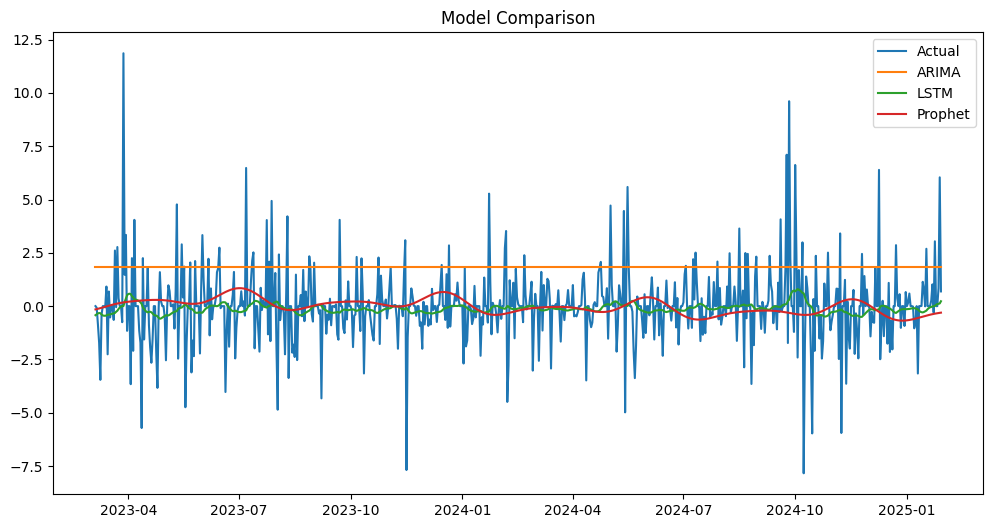

In [43]:
# Adjust the plotting to use the same range for all data
plt.figure(figsize=(12, 6))

# Slice test['Close'] to match the length of predictions for LSTM
plt.plot(test.index[seq_length:], test['Close_diff'].iloc[seq_length:], label='Actual')

plt.plot(test.index[seq_length:], arima_forecast[seq_length:], label='ARIMA')

plt.plot(test.index[seq_length:], predictions[:, 0], label='LSTM')  # Extract the first column of predictions

plt.plot(test.index[seq_length:], forecast['yhat'].iloc[seq_length:], label='Prophet')  # Slice forecast['yhat']

plt.legend()
plt.title('Model Comparison')
plt.show()